<a href="https://colab.research.google.com/github/alimomennasab/CS4210/blob/main/4210FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS4210-02 Machine Learning
## Fall 2024 Semester Project
Convolutional neural network model that classifies fish/shrimp from an image
### Members:
- Ali Momennasab
- Denise Thuong
- Eli Tolentino
- Armin Erika Polanco
- Sarah Choe
- Damian Varela


Imports

In [2]:
!pip install torchview

import torch
import torch.nn as nn
import torchvision
from torchview import draw_graph
import kagglehub


from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Data Preprocessing

In [3]:
# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.24G/3.24G [00:43<00:00, 80.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


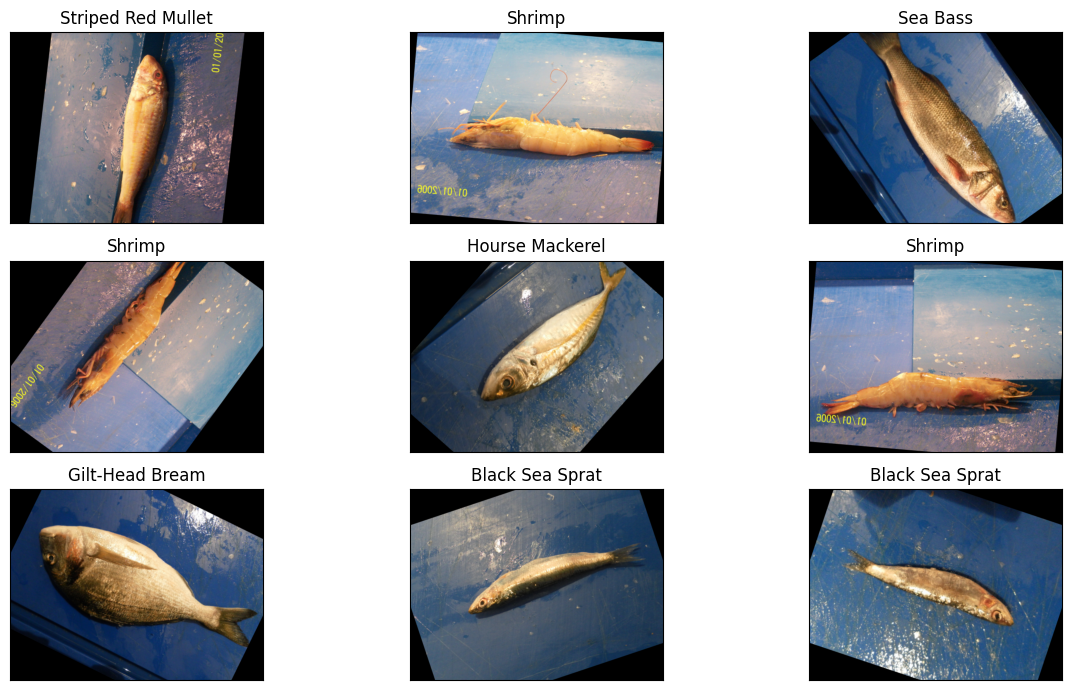

In [4]:
direc = Path(path)
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ] # ground truth images not needed for classification

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

In [7]:
# Data exploration
img_df.shape
img_df.columns

Index(['FilePaths', 'Labels'], dtype='object')